In [1]:
%config Completer.use_jedi = False # in case your autocomplete does not work

When you reach this stage you should have necessary skills and knowledge on PyTorch (including PL) and neural networks.
Now, let's focus more on a real image classification problem with a proper dataset.
That is, we won't use a handwritten digit dataset anymore, but use an RGB, real object dataset.
Let's discuss deep NN architectures first.

If you don't know about ImageNet and ILSVRC (arguably the biggest image classification challenge), I'll refer you to 

https://www.kaggle.com/getting-started/149448

Since 2017, ILSVRC is "hosted" by Kaggle. 
You can see the revolution of computer vision was started in 2012 when CNN (AlexNet) was first used to win the challenge with a significant margin.
Starting from there people started modify the AlexNet. 
(You can find that the architectures go deeper each year.)

Now, we don't have the luxury to test or reproduce each architecture one by one. 
Also, ImageNet is a massive dataset with its 1.2M training images. 
So, let's focus on a smaller-scale dataset and a shallower CNN architecture.
That is, we are gonna use CIFAR-10 (60000 32x32 colour images in 10 classes) and the CNN architecture that was proposed by Yan LeCun in 1999, called LeNet.


# Import and Subroutines

Nothing to read here. It'll be bunches of functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torchvision import datasets, transforms
from torchmetrics.functional import accuracy
# from pytorch_lightning.metrics.functional import accuracy
from torch.utils.data import DataLoader, random_split 


In [3]:
# the following is the original labels, but some words are too long
# cifar_classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship','truck')

# shorten the label
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse','ship','truck')

In [4]:
def tensor_to_imgnumpy(image: torch.Tensor, denormalize=False) -> np.ndarray:
    assert image.dim() == 3, f"expecting [3,32,32], the input size is {image.size()}" 
    
    imgnumpy = image.numpy()
    if denormalize:
        imgnumpy = imgnumpy*np.array([.5]) + np.array([.5])
    
    return imgnumpy.transpose(1,2,0)

In [5]:
def imshow(imgnumpy: np.ndarray, label, denormalize=False):
    plt.imshow(tensor_to_imgnumpy(imgnumpy,denormalize=denormalize))
    plt.title(cifar_classes[label])

# CIFAR-10

Always explore the dataset first!
Please find the relevant resource page on https://www.cs.toronto.edu/~kriz/cifar.html 


In [6]:
# download 

datasets.CIFAR10(
    root='./',
    download=True,
    train=True,
)

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

In [7]:
# transform

cifar_full=datasets.CIFAR10(
    root='./',
    train=True,
    transform=transforms.ToTensor()
)


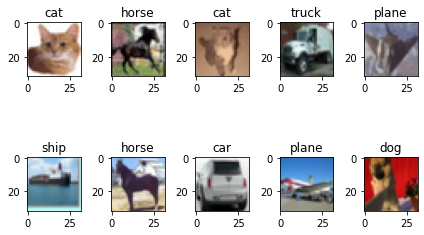

In [8]:
# dataloader and display

loader_cifar = DataLoader(cifar_full, batch_size=1, shuffle=True)

for idx,(img,label) in enumerate(loader_cifar):
    plt.subplot(2,5,idx+1)
    imshow(img[0],label)
    if idx == 10-1:
        break
        
plt.tight_layout()

# LeNet

We'll implement an archithecture that is similar to the following pict

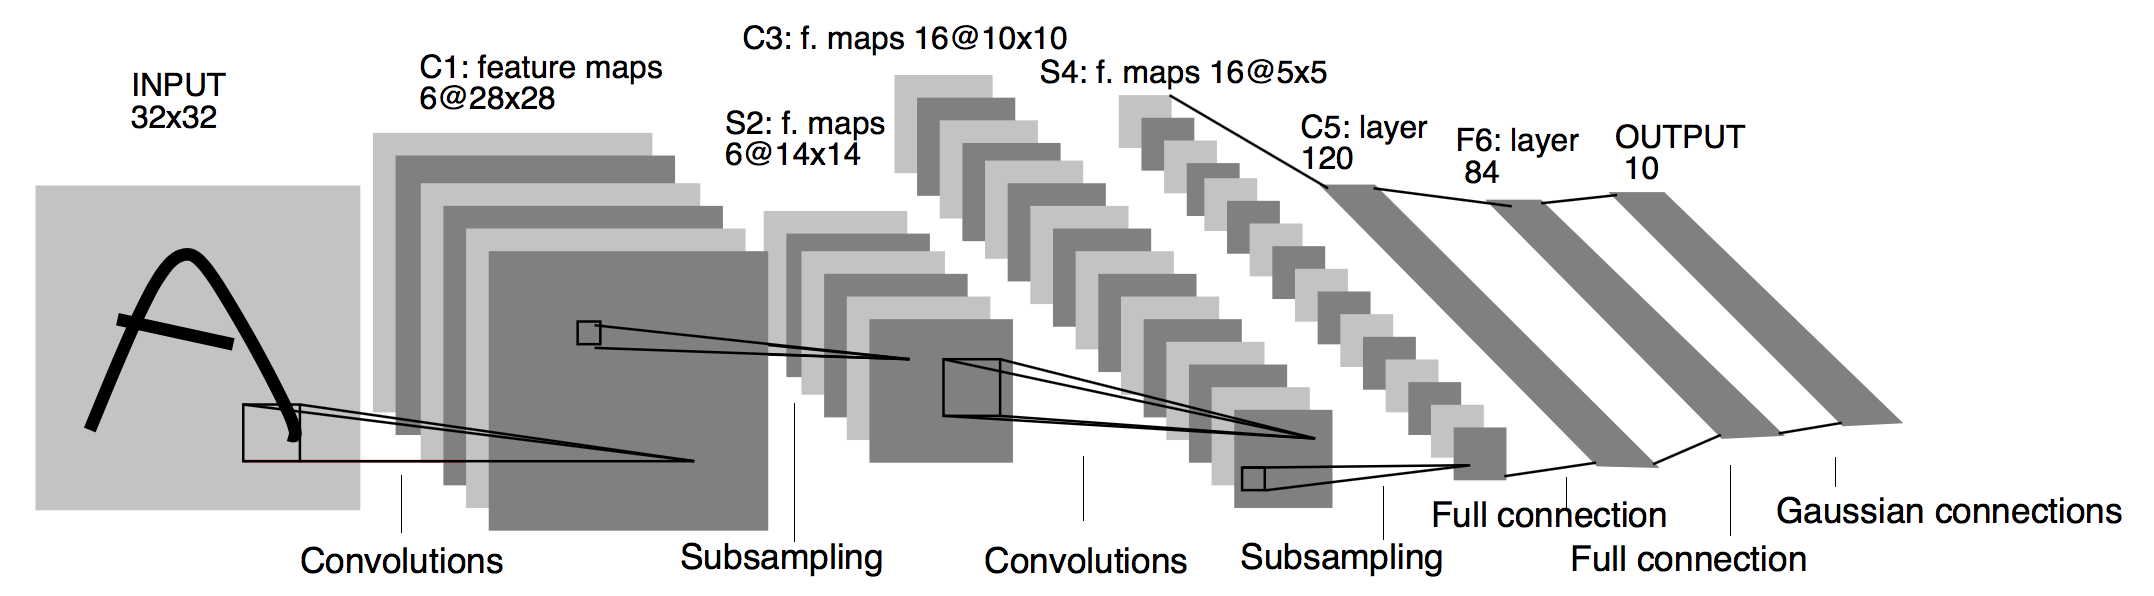

WARNING!

- We are not going to use a handwritten image, so the number of channel is 3 instead of 1. That is, the image dimensions are 3x32x32. 
- In today's language, 'Subsampling' is a pooling layer, and 'Gaussian connection' is softmax.

In [9]:
class LeNet(pl.LightningModule):
    def __init__(self,
                 num_input_ch = 3,
                 num_C1_ch = 6,
                 num_C3_ch = 16,
                 num_C5_neurons = 120,
                 num_F6_neurons = 84,
                 num_output_neurons = 10,
                 kernel_size_conv=(5,5), 
                 stride=1,
                 kernel_size_pool=(2,2),
                ):
        super().__init__()
        
        self.save_hyperparameters()
        
        self.C1 = nn.Conv2d(in_channels=self.hparams.num_input_ch,
                            out_channels=self.hparams.num_C1_ch,
                            kernel_size=self.hparams.kernel_size_conv,
                            stride=self.hparams.stride)
        self.Pool = nn.MaxPool2d(self.hparams.kernel_size_pool) 
        self.C2 = nn.Conv2d(in_channels=self.hparams.num_C1_ch,
                            out_channels=self.hparams.num_C3_ch,
                            kernel_size=self.hparams.kernel_size_conv,
                            stride=self.hparams.stride)
        
        # emulate to automatically (lazily) calculate the vector size for C5
        tmp = torch.zeros((1,3,32,32)) # 1 batch size, 3 RGB, 32x32 pixels, temp var to calculate the 1D vector to FNN
        
        tmp = self.C1(tmp)
        tmp = self.Pool(tmp)
        tmp = self.C2(tmp)
        tmp = self.Pool(tmp)
        
        self.hparams.num_C5_in_neurons = tmp.view(tmp.size(0),-1).size(1)

        self.C5 = nn.Linear(in_features=self.hparams.num_C5_in_neurons,out_features=self.hparams.num_C5_neurons)
        self.F6 = nn.Linear(in_features=self.hparams.num_C5_neurons,out_features=self.hparams.num_F6_neurons)
        self.OutputLayer = nn.Linear(in_features=self.hparams.num_F6_neurons,out_features=self.hparams.num_output_neurons)
        
        tf_resize = transforms.Resize((32,32)) # make sure that all loaded images have these dimensions
        tf_totensor = transforms.ToTensor() # Why? pytorch uses this datatype
        tf_normalize = transforms.Normalize(mean=((.5,.5,.5)),std=((.5,.5,.5))) 
        self.tf_compose = transforms.Compose([
            tf_resize,
            tf_totensor,
            tf_normalize,
        ])
        
    def forward(self,x):
        # x: [batch_size,3,32,32]
#         import pdb; pdb.set_trace()
#         if x.dim() == 2:
#             x = x.view((x.size(0),3,32,32))
            
        x = self.Pool(F.relu(self.C1(x)))
        x = self.Pool(F.relu(self.C2(x)))
        x = x.view(x.size(0),-1) # don't forget to flatten it
        x = F.relu(self.C5(x))
        x = F.relu(self.F6(x))
        x = self.OutputLayer(x) # we ouput the logits
        
        return x
    
    def training_step(self, batch, batch_idx):
        # Copy paste from the previous article
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels) # --> NEW. Using nn.CrossEntropyLoss
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # This is new, but the structure is the same as training_step
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels) # --> NEW
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        # This is new, but the structure is the same as test_step
        # but I replace val_loss --> test_loss etc
        inputs, labels = batch
        
        outputs = self.forward(inputs)
        loss = F.cross_entropy(outputs,labels)
        
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy(preds, labels)
        
        # Calling self.log will surface up scalars for you in TensorBoard
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    ####################
    # DATA RELATED HOOKS
    ####################

    def prepare_data(self):
        # download once
        datasets.CIFAR10(root='./', train=True, download=True)
        datasets.CIFAR10(root='./', train=False, download=True)
    
    def setup(self, stage=None):
        # split, transform, secretly move to GPU (if needed) by PL (not by us)
        if stage == 'fit' or stage is None:
            cifar_full = datasets.CIFAR10(root='./', train=True, transform=self.tf_compose)
            self.cifar_train, self.cifar_val = random_split(cifar_full, [45000, 5000])
            
        if stage == 'test' or stage is None:
            self.cifar_test = datasets.CIFAR10(root='./', train=False, transform=self.tf_compose)
            
#         import pdb; pdb.set_trace()
            
    def train_dataloader(self): 
        return DataLoader(self.cifar_train, batch_size=100, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.cifar_val, batch_size=100, num_workers=2)
    
    def test_dataloader(self):
        return DataLoader(self.cifar_test, batch_size=100, num_workers=2)

In [10]:
pl.seed_everything(1412) # --> for consistency, change the number with your favorite number :D

model = LeNet()

# most basic trainer, uses good defaults (auto-tensorboard, checkpoints, logs, and more)
try:
    trainer = pl.Trainer(gpus=1,max_epochs=20,default_root_dir='./cifar_logs')
except Exception as e:
    # most likely due to GPU, so fallback to non GPU
    print(e)
    trainer = pl.Trainer(max_epochs=20,default_root_dir='./cifar_logs')
    
trainer.fit(model)

Global seed set to 1412
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Files already downloaded and verified
Files already downloaded and verified


Missing logger folder: cifar_logs/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type      | Params
------------------------------------------
0 | C1          | Conv2d    | 456   
1 | Pool        | MaxPool2d | 0     
2 | C2          | Conv2d    | 2.4 K 
3 | C5          | Linear    | 48.1 K
4 | F6          | Linear    | 10.2 K
5 | OutputLayer | Linear    | 850   
------------------------------------------
62.0 K    Trainable params
0         Non-trainable params
62.0 K    Total params
0.248     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from to

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [11]:
%reload_ext tensorboard
%tensorboard --logdir cifar_logs/

In [12]:
trainer.test()

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1446: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `test(ckpt_path='best')` to use and best model checkpoint and avoid this warning or `ckpt_path=trainer.checkpoint_callback.last_model_path` to use the last model.
  rank_zero_warn(


Files already downloaded and verified
Files already downloaded and verified


Restoring states from the checkpoint path at cifar_logs/lightning_logs/version_0/checkpoints/epoch=19-step=9000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from checkpoint at cifar_logs/lightning_logs/version_0/checkpoints/epoch=19-step=9000.ckpt
/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

/home/ardimas/miniconda3/envs/pytorch_tutorial/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6083999872207642
        test_loss            1.237613320350647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.237613320350647, 'test_acc': 0.6083999872207642}]

Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

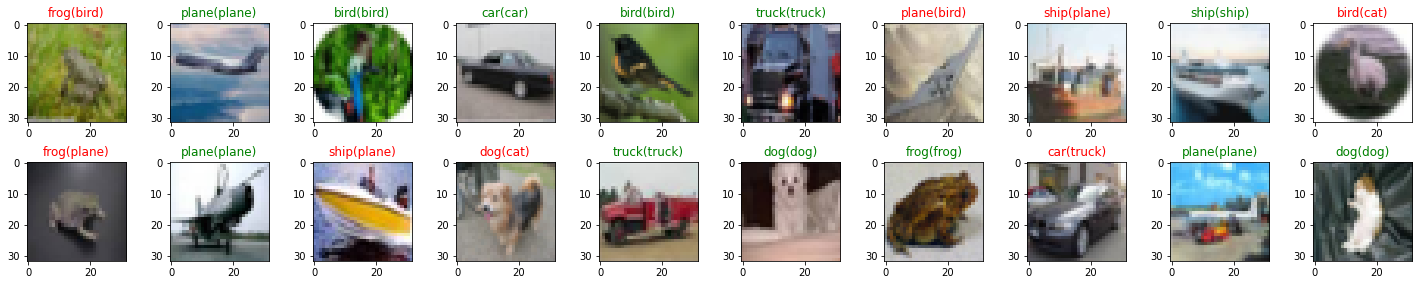

In [13]:
loader_cifar = DataLoader(model.cifar_test, batch_size=1, shuffle=True)

plt.figure(figsize=(20, 4))
for idx,(img,label) in enumerate(loader_cifar):
    plt.subplot(2,10,idx+1)
    imshow(img[0],label,denormalize=True)
    
    # inference
    try:
        pred = model.forward(img.cuda())
    except Exception as e:
        pred =  model.forward(img)
        print(e)

    title_dataset = cifar_classes[label]
    title_pred = cifar_classes[pred.argmax()]
    plt.title(f"{title_dataset}({title_pred})",color=("green" if title_dataset==title_pred else "red"))
    
    if idx == 20-1:
        break
        
plt.tight_layout()

The accuracy is pretty bad, isn't it? 

You can refer to, for example, https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py to see others' accuracy with the same architecture.

Now, it is your homework to submit a notebook and improve the current model.

The title of your notebook should use the following format.

'6. CNN_{your_name}' 

Change 'your_name' with your name